In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [ ]:
df = pd.read_csv('/content/data/amazon_reviews.csv')
print(df.shape)
df['ID'] = range(0, len(df))
df=df.head(500)
print(df.shape)
print(df.head)



(4915, 12)
(500, 13)
<bound method NDFrame.head of      Unnamed: 0      reviewerName  overall  \
0             0               NaN      4.0   
1             1              0mie      5.0   
2             2               1K3      4.0   
3             3               1m2      5.0   
4             4      2&amp;1/2Men      5.0   
..          ...               ...      ...   
495         495     AtlantaNative      5.0   
496         496        Atlashrggd      5.0   
497         497  A to Z Guarantee      5.0   
498         498         Audi A4B7      5.0   
499         499     Augie Gardino      5.0   

                                            reviewText  reviewTime  day_diff  \
0                                           No issues.  2014-07-23       138   
1    Purchased this for my device, it worked as adv...  2013-10-25       409   
2    it works as expected. I should have sprung for...  2012-12-23       715   
3    This think has worked out great.Had a diff. br...  2013-11-21       382

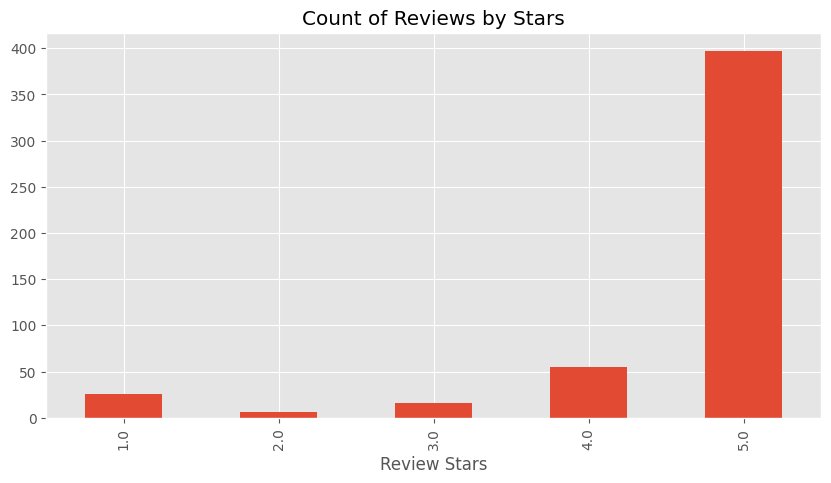

In [ ]:
ax = df['overall'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of Reviews by Stars',
          figsize=(10, 5))
ax.set_xlabel('Review Stars')
plt.show()

In [ ]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()
res = {}

for i, row in df.iterrows():
    text = row['reviewText']
    myid = row['ID']
    res[myid] = sia.polarity_scores(str(text))


vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index': 'ID'})
#print(vaders)
vaders = vaders.merge(df, how='left')
print(vaders.head)

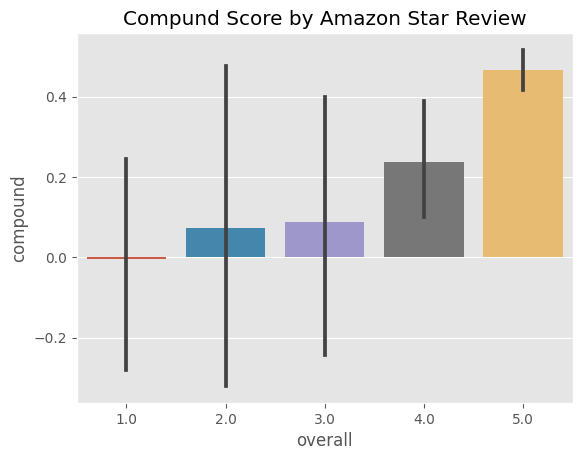

In [ ]:
ax = sns.barplot(data=vaders, x='overall', y='compound')
ax.set_title('Compund Score by Amazon Star Review')
plt.show()

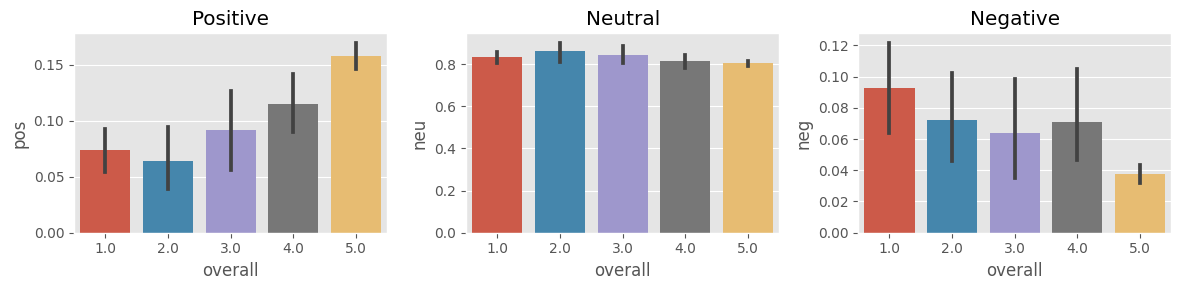

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=vaders, x='overall', y='pos', ax=axs[0])
sns.barplot(data=vaders, x='overall', y='neu', ax=axs[1])
sns.barplot(data=vaders, x='overall', y='neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

**ROBERTA PRETRAINING MODEL**

In [ ]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [ ]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [ ]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [ ]:
res = {}

for i, row in df.iterrows():
    try:
        text = row['reviewText']
        myid = row['ID']
        roberta_result = polarity_scores_roberta(str(text))
        res[myid] = roberta_result
    except RuntimeError:
        print(f'Broke for id {myid}')


Broke for id 76
Broke for id 123


In [ ]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'index': 'ID'})
results_df = results_df.merge(df, how='left')

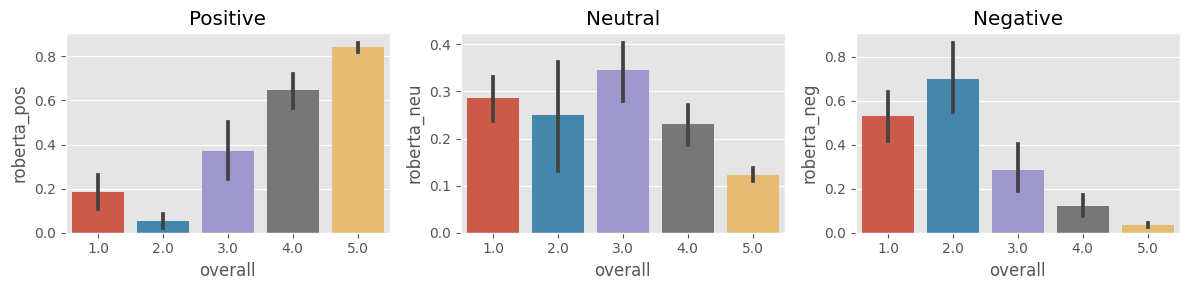

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=results_df, x='overall', y='roberta_pos', ax=axs[0])
sns.barplot(data=results_df, x='overall', y='roberta_neu', ax=axs[1])
sns.barplot(data=results_df, x='overall', y='roberta_neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

In [ ]:
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['reviewText']
        myid = row['ID']
        vader_result = sia.polarity_scores(str(text))
        vader_result_rename = {}
        for key, value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value
        roberta_result = polarity_scores_roberta(str(text))
        both = {**vader_result_rename, **roberta_result}
        res[myid] = both
    except RuntimeError:
        print(f'Broke for id {myid}')

  0%|          | 0/500 [00:00<?, ?it/s]

Broke for id 76
Broke for id 123


In [ ]:
resultsboth_df = pd.DataFrame(res).T
resultsboth_df = results_df.reset_index().rename(columns={'index': 'ID'})
resultsboth_df = results_df.merge(df, how='left')

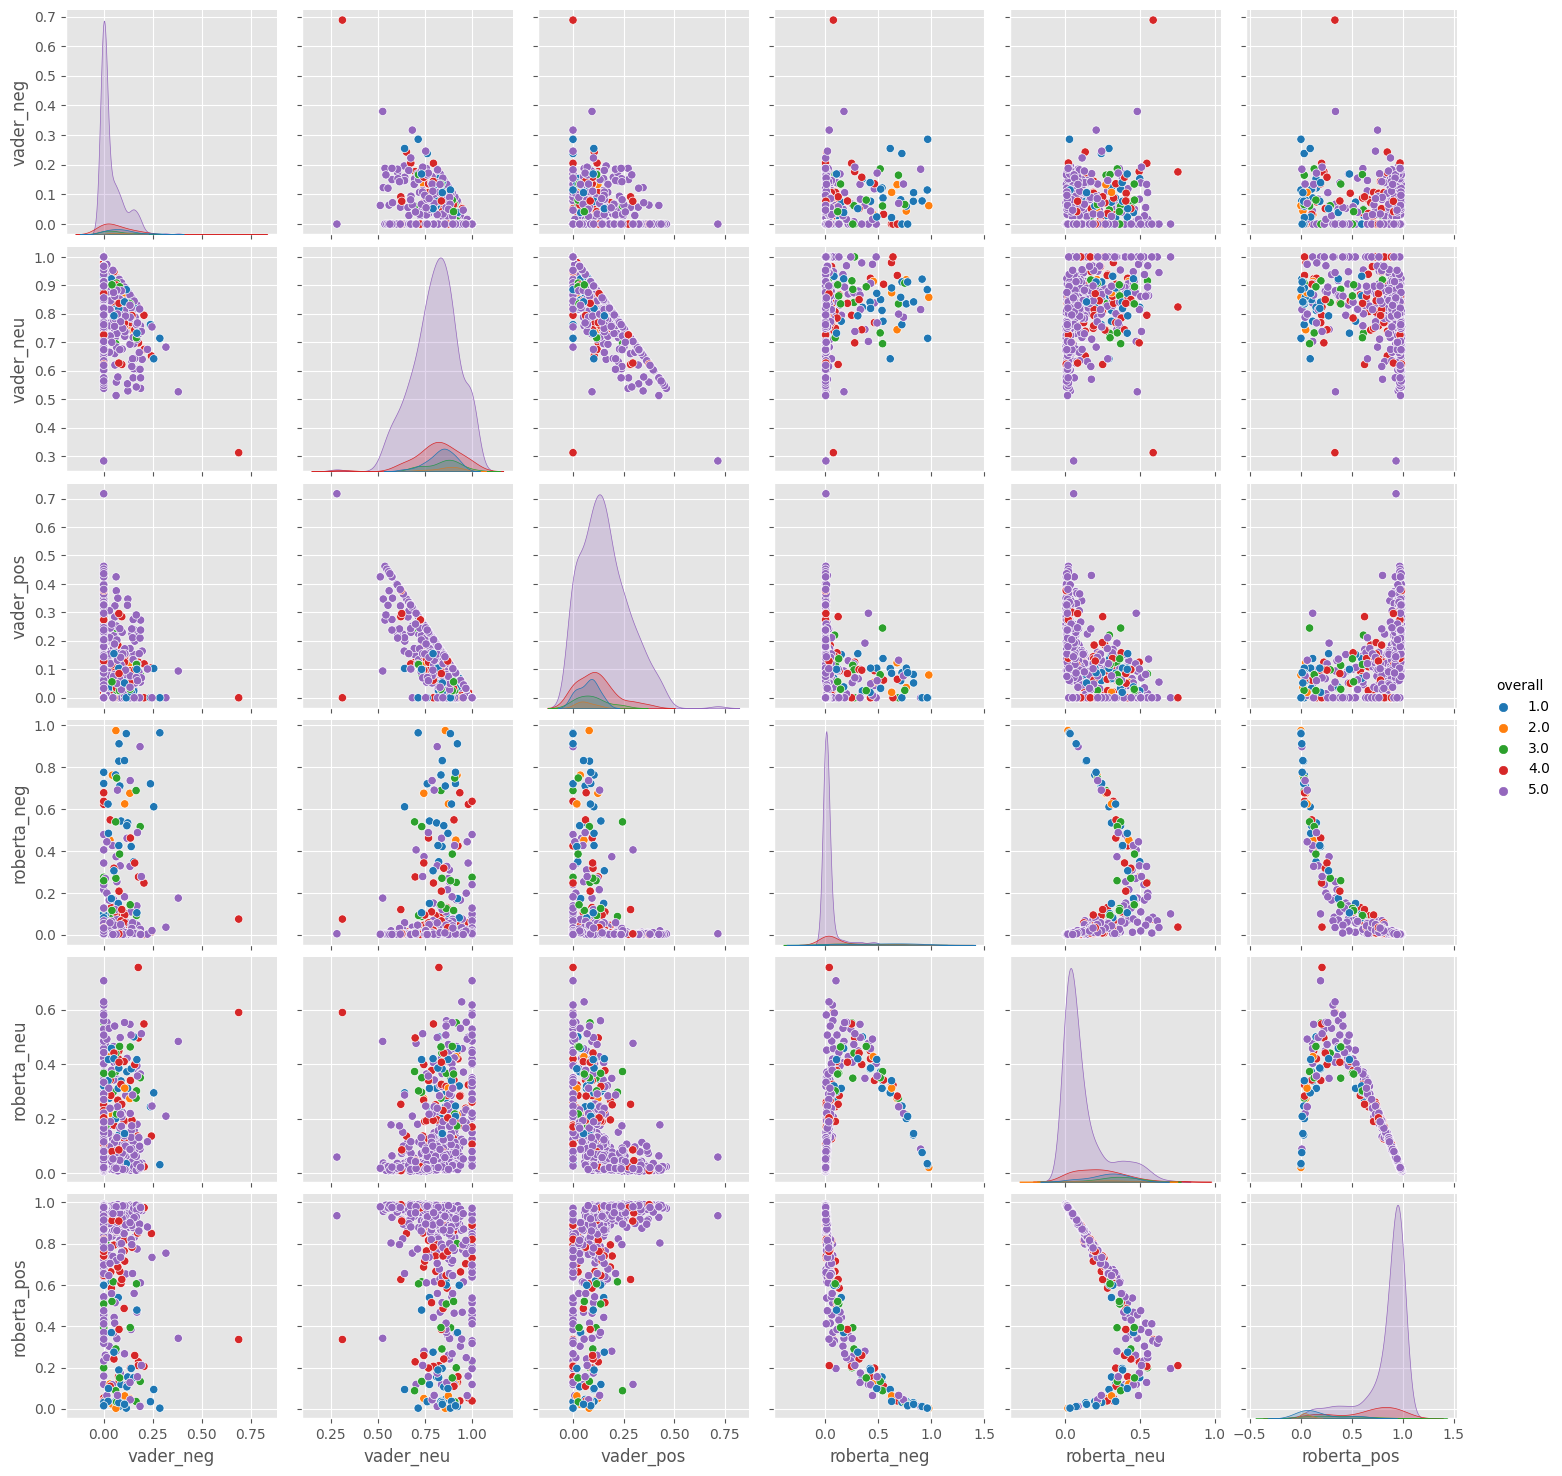

In [ ]:
sns.pairplot(data=resultsboth_df,
             vars=['vader_neg', 'vader_neu', 'vader_pos',
                  'roberta_neg', 'roberta_neu', 'roberta_pos'],
            hue='overall',
            palette='tab10')
plt.show()